# Instance Segmentation Computer Vision Local Inference using ONNX

**ONNX is an open format to represent both deep learning and traditional models**. 
<br>With ONNX, AI developers can more easily move models between state-of-the-art tools and choose the combination that is best for them. ONNX is developed and supported by a community of partners such as **Microsoft, Facebook and AWS.**

ONNX is widely supported and can be found in many frameworks, tools, and hardware. Enabling interoperability between different frameworks and streamlining the path from research to production helps increase the speed of innovation in the AI community. ONNX helps to solve the challenge of hardware dependency related to AI models and enables deploying same AI models to several HW accelerated targets.

> https://onnx.ai/

### We will use the ONNX model generated by Azure ML AutoML for Images to predict defects from images using local inference.

Documentation:
https://docs.microsoft.com/en-us/azure/machine-learning/how-to-inference-onnx-automl-image-models?tabs=instance-segmentation

<img src="https://microsoft.github.io/ai-at-edge/assets/images/ONNX.PNG">

In [1]:
import sys
import onnxruntime
import json
import numpy as np
import datetime
import azureml.core
import pandas as pd
import plotly.express as px
import urllib.request
from azureml.core import Workspace, Dataset, experiment
from zipfile import ZipFile

In [2]:
sys.version

'3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) \n[GCC 7.3.0]'

In [3]:
now = datetime.datetime.now()
print("Today:", now)

Today: 2022-01-05 13:20:45.463830


## 1. Azure ML Workspace

In [4]:
ws = Workspace.from_config()
print("Azure ML workspace:", ws.name, "\nAzure ML resource group:", ws.resource_group)

Azure ML workspace: azuremlvision 
Azure ML resource group: azuremlvision-rg


In [5]:
from azureml.core import Experiment

experiment_name = "AutoML-InstanceSegmentation-GlassDefect"
experiment = Experiment(ws, name=experiment_name)

In [6]:
experiment

Experiment(Name: AutoML-InstanceSegmentation-GlassDefect,
Workspace: azuremlvision)

## 2. Now we can download the ONNX model file format from the AutoML for Images experiment

In [7]:
# Select the best child run from the AutoML for Images run
from azureml.train.automl.run import AutoMLRun

run_id = "AutoML_694ff7ff-2a94-40b1-a433-1fef66010463" # Specify the run ID

automl_image_run = AutoMLRun(experiment=experiment, run_id=run_id)
best_child_run = automl_image_run.get_best_child()

### To use the ONNX inference we need 1) the ONNX model file and 2) the labels file

In [8]:
# Directory to store the results
ONNXDIR = 'ONNX'

In [9]:
if not os.path.isdir(ONNXDIR):
    print('The directory',  ONNXDIR, "is not present. Let's create it.")
    os.mkdir(ONNXDIR)
    print("Done.")
else:
    print('The directory', ONNXDIR, 'is present.')

The directory ONNX is not present. Let's create it.
Done.


In [10]:
for root, _, files in os.walk(ONNXDIR):
    print(root, "directory has", len(files), "files")

ONNX directory has 0 files


In [11]:
# Download the ONNX Instance Segmentation model
print("Download the ONNX file...")
best_child_run.download_file("train_artifacts/model.onnx", output_file_path=ONNXDIR + '/model.onnx')
print("Done.")

Download the ONNX file...
Done.


In [12]:
# Download the Computer Vision model Labels
print("Download the labels file...")
best_child_run.download_file("train_artifacts/labels.json", output_file_path=ONNXDIR + '/labels.json')
print("Done.")

Download the labels file...
Done.


In [13]:
for root, _, files in os.walk(ONNXDIR):
    print(root, "directory has", len(files), "files:")

files = [file for file in os.listdir(ONNXDIR)]
for file in files:
    print(file)

ONNX directory has 2 files:
labels.json
model.onnx


## 3. Let's test the ONNX inference on a single image

In [14]:
labels_file = ONNXDIR + '/labels.json'
onnx_model_path = ONNXDIR + '/model.onnx'

minconfidence = 0.7 # You can change the value for the minimum confidence value

### Image to analyze

In [15]:
test_image_path = 'test/defect3.png'

In [16]:
print("ONNX model:", onnx_model_path)
print("ONNX runtime version:", onnxruntime.__version__)
print("Labels file:", labels_file)
print("\nImage to test:", test_image_path)
print("Minimum Confidence value =", minconfidence)

ONNX model: ONNX/model.onnx
ONNX runtime version: 1.8.0
Labels file: ONNX/labels.json

Image to test: test/defect3.png
Minimum Confidence value = 0.7


In [17]:
# Opening the ONNX session
try:
    session = onnxruntime.InferenceSession(onnx_model_path)
    print("ONNX model loaded...")
except Exception as e: 
    print("Error loading ONNX file: ",str(e))

sess_input = session.get_inputs()
sess_output = session.get_outputs()
print()
print(f"No. of inputs: {len(sess_input)}, No. of outputs: {len(sess_output)}")
print()

for idx, input_ in enumerate(range(len(sess_input))):
    input_name = sess_input[input_].name
    input_shape = sess_input[input_].shape
    input_type = sess_input[input_].type
    print(f"{idx} Input name: { input_name }, Input shape: {input_shape}, \
    Input type: {input_type}")  

print()

for idx, output in enumerate(range(len(sess_output))):
    output_name = sess_output[output].name
    output_shape = sess_output[output].shape
    output_type = sess_output[output].type
    print(f" {idx} Output name: {output_name}, Output shape: {output_shape}, \
    Output type: {output_type}") 

ONNX model loaded...

No. of inputs: 1, No. of outputs: 4

0 Input name: input, Input shape: ['batch', 'channel', 'height', 'width'],     Input type: tensor(float)

 0 Output name: boxes, Output shape: ['prediction', 4],     Output type: tensor(float)
 1 Output name: labels, Output shape: ['prediction'],     Output type: tensor(int64)
 2 Output name: scores, Output shape: ['prediction'],     Output type: tensor(float)
 3 Output name: masks, Output shape: ['prediction', 1, 'height', 'width'],     Output type: tensor(float)


In [18]:
# Image preprocessing
def preprocess(image, resize_height, resize_width):
    """perform pre-processing on raw input image
        
    :param image: raw input image
    :type image: PIL image
    :param resize_height: resize height of an input image
    :type resize_height: Int
    :param resize_width: resize width of an input image
    :type resize_width: Int
    :return: pre-processed image in numpy format
    :rtype: ndarray of shape 1xCxHxW
    """

    image = image.convert('RGB')
    image = image.resize((resize_width,resize_height))
    np_image = np.array(image)

    # HWC -> CHW
    np_image = np_image.transpose(2, 0, 1)# CxHxW

    # normalize the image
    mean_vec = np.array([0.485, 0.456, 0.406])
    std_vec = np.array([0.229, 0.224, 0.225])
    norm_img_data = np.zeros(np_image.shape).astype('float32')

    for i in range(np_image.shape[0]):
        norm_img_data[i,:,:] = (np_image[i,:,:]/255 - mean_vec[i]) / std_vec[i]
    np_image = np.expand_dims(norm_img_data, axis=0)# 1xCxHxW
    
    return np_image

Image filename: test/defect3.png
Input image dimensions: (1471, 748)


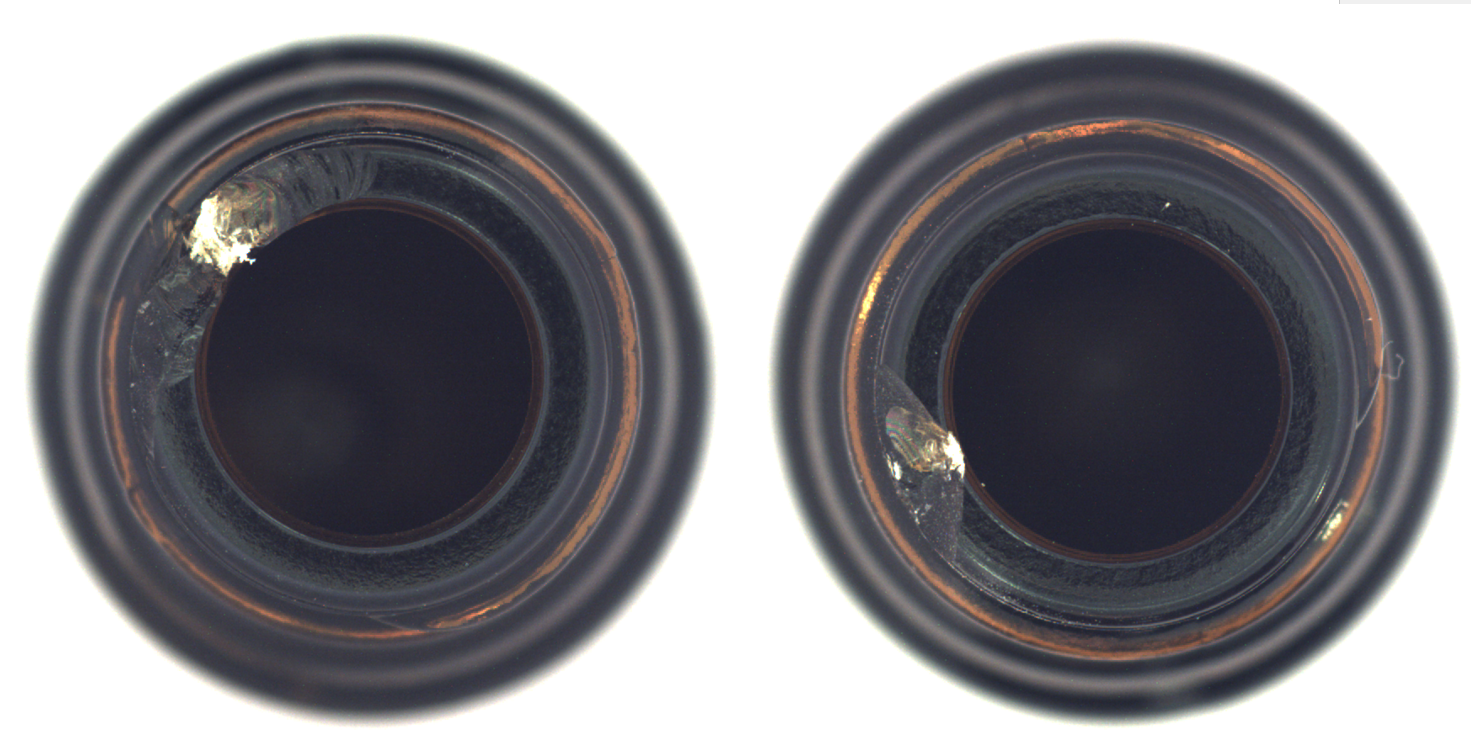

In [19]:
from PIL import Image
# use height and width based on the trained model
resize_height, resize_width = 600, 800 
print("Image filename:", test_image_path)
img = Image.open(test_image_path)
print("Input image dimensions:", img.size)
display(img)

img_data = preprocess(img, resize_height, resize_width)

In [20]:
# Get Predictions from ONNX session
def get_predictions_from_ONNX(onnx_session,img_data):
    """perform predictions with ONNX Runtime
    
    :param onnx_session: onnx model session
    :type onnx_session: class InferenceSession
    :param img_data: pre-processed numpy image
    :type img_data: ndarray with shape 1xCxHxW
    :return: boxes, labels , scores , masks with shapes
            (No. of instances, 4) (No. of instances,) (No. of instances,)
            (No. of instances, 1, HEIGHT, WIDTH))  
    :rtype: tuple
    """
    print("Get predictions from ONNX ...")
    sess_input = onnx_session.get_inputs()
    sess_output = onnx_session.get_outputs()
    
    # predict with ONNX Runtime
    output_names = [ output.name for output in sess_output]
    boxes, labels, scores, masks = onnx_session.run(output_names=output_names,\
                                               input_feed={sess_input[0].name: img_data})
    print("Done!\n")
    return boxes, labels, scores, masks

In [21]:
print("Analysing image:", test_image_path, "\n")

boxes, labels, scores, masks = get_predictions_from_ONNX(session, img_data)

nbdefects = 0
totaldefects = 0

for nbdefects in range(0, len(scores)):
    if scores[nbdefects] > minconfidence:
        totaldefects +=1
        print("\033[1;31;34m", totaldefects, ": Defect has been detected with a confidence =", scores[nbdefects])
        print("Region of interest:", boxes[nbdefects], "\n")

print("\033[1;31;91m=> Total of detected defects =", totaldefects, "on image:", test_image_path)

Analysing image: test/defect3.png 

Get predictions from ONNX ...
Done!

 1 : Defect has been detected with a confidence = 0.9867628
Region of interest: [ 65.2507  122.9068  196.8823  315.85144] 

 2 : Defect has been detected with a confidence = 0.94024086
Region of interest: [475.87735 308.32037 527.5464  440.15143] 

=> Total of detected defects = 2 on image: test/defect3.png


In [22]:
onnxoutputfile = ONNXDIR + '/ONNX.csv'

In [23]:
if os.path.exists(onnxoutputfile):
    print("File", onnxoutputfile, "exists.")
else:
    print("Creating the file headers...")
    file_object = open(onnxoutputfile, 'a')
    file_object.write("Date" + ',' + 'ImageFile' + ',' + 'NumberofDefects' + '\n')
    print("Done.")
    file_object.close()

Creating the file headers...
Done.


In [24]:
print("Saving results into the file...")
file_object = open(onnxoutputfile, 'a')
file_object.write(str(datetime.datetime.now()) + ',' + str(test_image_path) + ',' + str(totaldefects) + '\n')
file_object.close()
print("Done!")

Saving results into the file...
Done!


In [25]:
# Let's view the results file
with open(os.path.join(onnxoutputfile), 'r') as f:
    print(f.read())

Date,ImageFile,NumberofDefects
2022-01-05 13:21:05.893351,test/defect3.png,2



## 4. Multiple Inferences with ONNX

Let's run the ONNX inference on all the files from a directory

In [26]:
# Directory to analyse
MYDIR = 'testsimages'

In [27]:
if not os.path.isdir(MYDIR):
    print('The directory',  MYDIR, "is not present. Let's create it.")
    os.mkdir(MYDIR)
    print("Done.")
else:
    print('The directory', MYDIR, 'is present.')

The directory testsimages is not present. Let's create it.
Done.


In [28]:
os.chdir(MYDIR)

In [29]:
os.getcwd()

'/mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow9/code/Users/seretkow/AutoMLforImages/GlassDefect/testsimages'

In [31]:
# Downloading images into the directory MYDIR
download_url = 'https://github.com/retkowsky/InstanceSegmentation/blob/main/tests/testsimages.zip?raw=true'
zip_file = 'testsimages.zip'

print("Download the zip file:", zip_file)
urllib.request.urlretrieve(download_url, filename=zip_file)
print('Done!\n')

# Unzip file
with ZipFile(zip_file, 'r') as zip:
    print('Unzip', zip_file, '...')
    zip.extractall()
    print('Done.\n')
    
# Delete the downloaded zip file
print("Deleting", zip_file)
os.remove(zip_file)
print("Done.")

Download the zip file: testsimages.zip
Done!

Unzip testsimages.zip ...
Done.

Deleting testsimages.zip
Done.


In [32]:
os.chdir('..')
os.getcwd()

'/mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow9/code/Users/seretkow/AutoMLforImages/GlassDefect'

In [33]:
for root, _, files in os.walk(MYDIR):
    nbimages = len(files)
    print('Directory:', root, "has", nbimages, "images files")

Directory: testsimages has 47 images files


In [34]:
print("So let's predict the", nbimages, "images with local ONNX inference.")

So let's predict the 47 images with local ONNX inference.


In [35]:
# Name of the output file to create
onnxoutputfilebatch = ONNXDIR + '/ONNXbatch.csv'

In [36]:
if os.path.exists(onnxoutputfilebatch):
    print("File", onnxoutputfilebatch, "exists.")

else:
    print("Creating the file headers...")
    file_object = open(onnxoutputfilebatch, 'a')
    file_object.write("Date" + ',' + 'ImageFile' + ',' + 'NumberofDefects' + '\n')
    print("Done.")
    file_object.close()

Creating the file headers...
Done.


In [37]:
minconfidence = 0.7 # You can change the value for the minimum confidence value

In [38]:
images = [file for file in os.listdir(MYDIR) if file.endswith(('png'))]

t1 = datetime.datetime.now()
i = 1

for image in images:
    imagelocation = MYDIR + '/' + image
    print(i, '\t', datetime.datetime.now(), 'Analyzing image:', imagelocation)
    print()
    img = Image.open(imagelocation)
    img_data = preprocess(img, resize_height, resize_width)
    boxes, labels, scores, masks = get_predictions_from_ONNX(session, img_data)
    nbdefects = 0
    totaldefects = 0

    for nbdefects in range(0, len(scores)):
        if scores[nbdefects] > minconfidence:
            totaldefects +=1
            print(totaldefects, ": Defect has been detected with a confidence =", scores[nbdefects])
            print("Region of interest:", boxes[nbdefects], "\n")

    print("Total of detected defects =", totaldefects, "on image:", imagelocation)
    print("\n-------------------------------------------------------------------------\n")
    
    file_object = open(onnxoutputfilebatch, 'a')
    file_object.write(str(datetime.datetime.now()) + ',' + str(imagelocation) + ',' + str(totaldefects) + '\n')
    file_object.close()
    i+=1
    
t2 = datetime.datetime.now()
print("Done.", i-1, "images were analysed.", "Time:", t2 - t1)

1 	 2022-01-05 13:21:56.706705 Analyzing image: testsimages/testimage (1).png

Get predictions from ONNX ...
Done!

Total of detected defects = 0 on image: testsimages/testimage (1).png

-------------------------------------------------------------------------

2 	 2022-01-05 13:21:59.178738 Analyzing image: testsimages/testimage (10).png

Get predictions from ONNX ...
Done!

Total of detected defects = 0 on image: testsimages/testimage (10).png

-------------------------------------------------------------------------

3 	 2022-01-05 13:22:01.339235 Analyzing image: testsimages/testimage (11).png

Get predictions from ONNX ...
Done!

Total of detected defects = 0 on image: testsimages/testimage (11).png

-------------------------------------------------------------------------

4 	 2022-01-05 13:22:03.603829 Analyzing image: testsimages/testimage (12).png

Get predictions from ONNX ...
Done!

Total of detected defects = 0 on image: testsimages/testimage (12).png

---------------------

Done!

1 : Defect has been detected with a confidence = 0.82445633
Region of interest: [139.86653 372.11118 181.88841 415.74673] 

Total of detected defects = 1 on image: testsimages/testimage (38).png

-------------------------------------------------------------------------

33 	 2022-01-05 13:23:05.951526 Analyzing image: testsimages/testimage (39).png

Get predictions from ONNX ...
Done!

Total of detected defects = 0 on image: testsimages/testimage (39).png

-------------------------------------------------------------------------

34 	 2022-01-05 13:23:08.057244 Analyzing image: testsimages/testimage (4).png

Get predictions from ONNX ...
Done!

Total of detected defects = 0 on image: testsimages/testimage (4).png

-------------------------------------------------------------------------

35 	 2022-01-05 13:23:10.289506 Analyzing image: testsimages/testimage (40).png

Get predictions from ONNX ...
Done!

Total of detected defects = 0 on image: testsimages/testimage (40).png

----

### Results

In [39]:
# Display the CSV results file
with open(os.path.join(onnxoutputfilebatch), 'r') as myfile:
    print(myfile.read())

Date,ImageFile,NumberofDefects
2022-01-05 13:21:59.166802,testsimages/testimage (1).png,0
2022-01-05 13:22:01.327037,testsimages/testimage (10).png,0
2022-01-05 13:22:03.582273,testsimages/testimage (11).png,0
2022-01-05 13:22:05.727737,testsimages/testimage (12).png,0
2022-01-05 13:22:07.825789,testsimages/testimage (13).png,0
2022-01-05 13:22:10.101253,testsimages/testimage (14).png,0
2022-01-05 13:22:12.250023,testsimages/testimage (15).png,0
2022-01-05 13:22:14.424387,testsimages/testimage (16).png,0
2022-01-05 13:22:16.563334,testsimages/testimage (17).png,0
2022-01-05 13:22:18.747856,testsimages/testimage (18).png,0
2022-01-05 13:22:20.937884,testsimages/testimage (19).png,0
2022-01-05 13:22:23.088641,testsimages/testimage (2).png,0
2022-01-05 13:22:25.208583,testsimages/testimage (20).png,0
2022-01-05 13:22:27.319182,testsimages/testimage (21).png,0
2022-01-05 13:22:29.497521,testsimages/testimage (22).png,0
2022-01-05 13:22:31.639728,testsimages/testimage (23).png,0
2022-01-05 

In [40]:
# Link to download the file
from IPython.display import FileLink

MYLINK = FileLink(path=onnxoutputfilebatch)
print(">> Click to download the results CSV file:")
MYLINK

>> Click to download the results CSV file:


/mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow9/code/Users/seretkow/AutoMLforImages/GlassDefect/ONNX/ONNXbatch.csv

### Results analysis

In [41]:
df_onnx_batch = pd.read_csv(onnxoutputfilebatch)

In [42]:
df_onnx_batch.shape

(47, 3)

In [46]:
# Let's display some random values 
df_onnx_batch.sample(n = 20)

Date                       ImageFile  \
34  2022-01-05 13:23:12.451418  testsimages/testimage (40).png   
22  2022-01-05 13:22:46.729335   testsimages/testimage (3).png   
14  2022-01-05 13:22:29.497521  testsimages/testimage (22).png   
4   2022-01-05 13:22:07.825789  testsimages/testimage (13).png   
6   2022-01-05 13:22:12.250023  testsimages/testimage (15).png   
11  2022-01-05 13:22:23.088641   testsimages/testimage (2).png   
39  2022-01-05 13:23:23.343204  testsimages/testimage (45).png   
46  2022-01-05 13:23:38.572367   testsimages/testimage (9).png   
13  2022-01-05 13:22:27.319182  testsimages/testimage (21).png   
18  2022-01-05 13:22:38.129027  testsimages/testimage (26).png   
36  2022-01-05 13:23:16.680386  testsimages/testimage (42).png   
8   2022-01-05 13:22:16.563334  testsimages/testimage (17).png   
23  2022-01-05 13:22:48.853872  testsimages/testimage (30).png   
15  2022-01-05 13:22:31.639728  testsimages/testimage (23).png   
38  2022-01-05 13:23:21.125590  testsimages/testimage (44).png   
19  2022-01-05 13:22:40.237983  testsimages/testimage (27).png   
40  2022-01-05 13:23:25.488347  testsimages/testimage (46).png   
37  2022-01-05 13:23:18.849002  testsimages/testimage (43).png   
2   2022-01-05 13:22:03.582273  testsimages/testimage (11).png   
32  2022-01-05 13:23:08.040788  testsimages/testimage (39).png   

    NumberofDefects  
34                0  
22                0  
14                0  
4                 0  
6                 0  
11                0  
39                3  
46                0  
13                0  
18                0  
36                0  
8                 0  
23                0  
15                0  
38                0  
19                0  
40                1  
37                0  
2                 0  
32                0

In [44]:
df_onnx_batch.describe()

NumberofDefects
count        47.000000
mean          0.148936
std           0.550838
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           3.000000

### Distribution

In [47]:
print("Distribution of detected defects:")
df_valuecounts = df_onnx_batch['NumberofDefects'].value_counts().to_frame()
df_valuecounts = df_valuecounts.sort_index(axis = 0)
df_valuecounts

Distribution of detected defects:


NumberofDefects
0               43
1                2
2                1
3                1

In [48]:
print("Distribution of detected defects in %")
df_valuepctcounts = df_onnx_batch['NumberofDefects'].value_counts(normalize=True).to_frame()
df_valuepctcounts = df_valuepctcounts.sort_index(axis = 0)
df_valuepctcounts

Distribution of detected defects in %


NumberofDefects
0         0.914894
1         0.042553
2         0.021277
3         0.021277

In [49]:
zero_defect = df_valuecounts.iloc[[0]].loc[0,'NumberofDefects']
pct_zero_defect = zero_defect / len(df_onnx_batch) * 100
no_zero_defect = len(df_onnx_batch) - zero_defect
pct_no_zero_defect = no_zero_defect / len(df_onnx_batch) * 100

print("Number of images with zero defect:\t", zero_defect, '\t(', round(pct_zero_defect, 2), '% )')
print("Number of images with some defect(s):\t", no_zero_defect, '\t(', round(pct_no_zero_defect, 2), '% )')

Number of images with zero defect:	 43 	( 91.49 % )
Number of images with some defect(s):	 4 	( 8.51 % )


In [50]:
pie = px.pie(df_onnx_batch,
             names='NumberofDefects',
             title='Percentage of Detected Defects distribution using AutoML for Images and ONNX Inference',
             color='NumberofDefects',
             color_discrete_map = {0 : 'green', 1 : 'orange', 2 : 'darkorange', 3 : 'red'},
             )

pie.show()

In [51]:
hist = px.histogram(df_onnx_batch, 
                    x="NumberofDefects",
                    title='Number of Detected Defects distribution using AutoML for Images and ONNX Inference',
                    color='NumberofDefects',
                    color_discrete_map = {0 : 'green', 1 : 'orange', 2 : 'darkorange', 3 : 'red'} )

hist.show()

In [52]:
print("\033[1;31;34mPowered by Azure AutoML for Images", azureml.core.VERSION, "and ONNX", onnxruntime.__version__)

Powered by Azure AutoML for Images 1.34.0 and ONNX 1.8.0
